In [1]:
%pylab inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os

Populating the interactive namespace from numpy and matplotlib


In [17]:
!pip install --quiet git+https://github.com/liuxx479/Outlier.git
from outlier.datasets import gaussian_convergence

In [0]:
import tensorflow_datasets as tfds

In [0]:
####### JL: vanessa path
# root      = '/global/cscratch1/sd/vboehm'
# data_path = os.path.join(root,'Datasets/Gaussian_Kappa/')
# model_path= os.path.join(root,'Models/Gaussian_Kappa')

####### JL path

from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive'
data_path = os.path.join(root,'tensorflow_datasets/')
model_path= os.path.join(root,'models')

if not os.path.isdir(model_path):
    os.makedirs(model_path)

In [19]:
VERSION = tfds.core.Version('0.1.0')
data_set, info = tfds.load(name="gaussian_convergence", download=0, split="train", data_dir=data_path, with_info=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /content/drive/My Drive/tensorflow_datasets/gaussian_convergence/0.1.0.incompleteDZ9N7Q/gaussian_convergence-train.tfrecord



Dataset gaussian_convergence downloaded and prepared to /content/drive/My Drive/tensorflow_datasets/gaussian_convergence/0.1.0. Subsequent calls will reuse this data.


In [0]:
DATASET_SIZE = info.splits['train'].num_examples

In [21]:
print (data_path)
print (DATASET_SIZE)

/content/drive/My Drive/tensorflow_datasets/
20000


tf.Tensor([0.16992588 0.7251126 ], shape=(2,), dtype=float32)


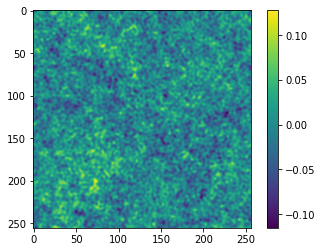

In [22]:
for example in data_set.take(1):  # Only take a single example
    kappa_map, params = example["map"], example["params"]
    imshow(np.squeeze(kappa_map))
    print(params)
    colorbar()

In [23]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

full_dataset = data_set
full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)
train_dataset= full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset  = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

print(train_dataset)

<DatasetV1Adapter shapes: {map: (256, 256), params: (2,)}, types: {map: tf.float32, params: tf.float32}>


In [41]:
print (train_size, val_size, test_size)

14000 3000 3000


In [0]:
def redefine(data):
    x    = data['map'] 
    x    = tf.expand_dims(x,-1)
    y    = data['params']
    return x,y

def whiten(x,y):
    mean = tf.reduce_mean(x, axis=[1,2])
    print(mean.shape)
    std  = tf.math.reduce_std(x, axis=[1,2])
    print(std.shape)
    x    = (x-mean)/std
    x    = tf.expand_dims(x,-1)   
    return x, y

def downsample(x,y):
    x    = tf.image.resize(x,[128,128])
    return x, y

In [0]:
train_dataset = train_dataset.batch(32).shuffle(1000)
train_dataset = train_dataset.map(redefine)
train_dataset = train_dataset.map(downsample)
train_dataset = train_dataset.repeat()

In [0]:
val_dataset = val_dataset.batch(64).shuffle(1000)
val_dataset = val_dataset.map(redefine)
val_dataset = val_dataset.map(downsample)
val_dataset = val_dataset.repeat()

In [0]:
test_dataset = test_dataset.map(redefine)
test_dataset = test_dataset.map(downsample).batch(256)

In [0]:
def res_net_block(input_data, filters, conv_size):
    x = layers.Conv2D(filters, conv_size, activation='relu', padding='same')(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, conv_size, activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, input_data])
    x = layers.Activation('relu')(x)
    return x

In [0]:
def non_res_block(input_data, filters, conv_size):
    x = layers.Conv2D(filters, conv_size, activation='relu', padding='same')(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, conv_size, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    return x

In [0]:
inputs = keras.Input(shape=(128, 128, 1))
x = layers.Conv2D(32, 5, activation='relu')(inputs)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
num_res_net_blocks = 3
for i in range(num_res_net_blocks):
    x = res_net_block(x, 64, 3)
x = layers.Conv2D(64, 2, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(2)(x)

res_net_model = keras.Model(inputs, outputs)

In [31]:
res_net_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 124, 124, 32) 832         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 122, 122, 64) 18496       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 61, 61, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
checkpoint_file = os.path.join(model_path+'/weights.{epoch:02d}-{val_loss:.2f}.hdf5')
ckpt_callback   = keras.callbacks.ModelCheckpoint(filepath=checkpoint_file, monitor='val_loss')
hists = []

In [0]:
def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    try:
        return max(paths, key=os.path.getctime)
    except:
        return None

In [34]:
latest_file=newest(model_path)
print(latest_file)

None


In [35]:
callbacks     = [ckpt_callback]
if latest_file is None:
    res_net_model.compile(optimizer=keras.optimizers.Adam(),loss='mse',metrics=['mse'])   
else:
    res_net_model = keras.models.load_model(latest_file)
history = res_net_model.fit(train_dataset, epochs=1, steps_per_epoch=200,validation_data=val_dataset,verbose=1,validation_steps=3, callbacks=callbacks)
hists.append(history)

200/200 [==============================] - 130s 652ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.0323 - val_mse: 0.0323


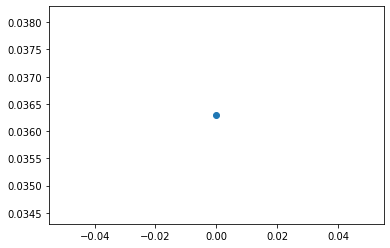

In [36]:
plt.plot(history.history['mse'], marker='o')

In [0]:
predictions = res_net_model.predict(test_dataset)

In [38]:
predictions.shape

(3000, 2)

In [0]:
truth = list(test_dataset.as_numpy_iterator()) 

In [65]:
params_input = np.array([idata[1] for idata in truth])
params_input = concatenate(params_input, axis=0)
print (params_input.shape)

(3000, 2)


In [0]:
S8_gen= lambda params: sqrt(params.T[0]/0.3)*params.T[1]

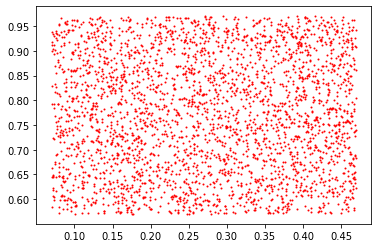

In [68]:
#plt.plot( truth[0][1][:,0],truth[0][1][:,1], marker='o', ls='')

scatter(params_input.T[0], params_input.T[1],color='r',s=1)

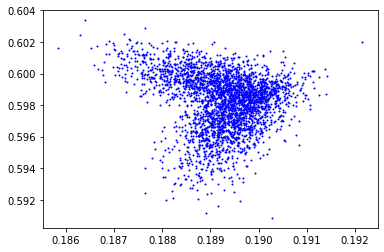

In [69]:
scatter(predictions.T[0], predictions.T[1],color='b',s=1)

In [0]:
#plt.plot( np.asarray(predictions[0:256,0]),np.asarray(predictions[0:256,1]), marker='o', ls='')

In [0]:
# def get_S8(As,om):
#     S8=(As+2.1)/7.915*sqrt(om/0.3)
#     return S8

In [0]:
res_net_model.train_on_batch

<bound method Model.train_on_batch of <tensorflow.python.keras.engine.training.Model object at 0x2aab8c6b6750>>

In [0]:
# true_s8 = get_S8(truth[0][1][:,0],truth[0][1][:,1])
# pred_s8 = get_S8(np.asarray(predictions[0:256,0]),np.asarray(predictions[0:256,1]))

true_s8=S8_gen(params_input)
pred_s8=S8_gen(predictions)

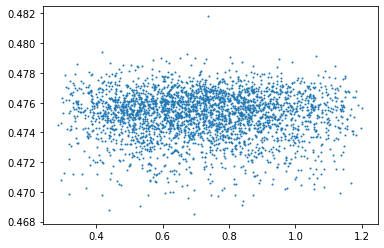

In [74]:
plt.scatter(true_s8, pred_s8, s=1)